## Imports

In [1]:
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from bbtoolkit.preprocessing.neural_generators import MTLGenerator,\
    HDGenerator,\
    TCGenerator,\
    GCGenerator, GCMap,\
    PCGenerator
import configparser
from bbtoolkit.data.configparser import EvalConfigParser
import numpy as np
from bbtoolkit.preprocessing.environment import Environment
from bbtoolkit.preprocessing.environment.builders import EnvironmentBuilder

## Create environment

In [36]:
env = Environment.load('../data/envs/main_environment.pkl')

In [2]:
env = Environment.load('../data/envs/square_environment.pkl')

In [8]:
env = Environment.load('../data/envs/square_environment_small.pkl')

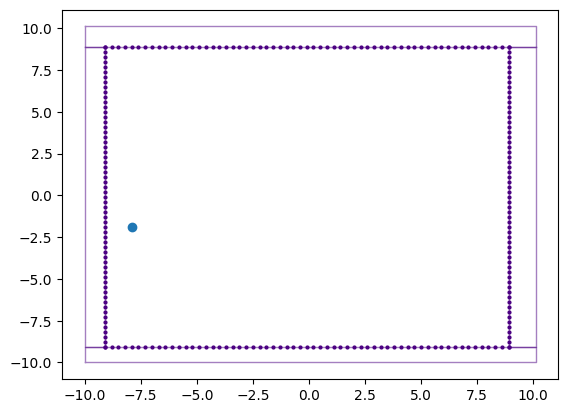

In [3]:
from bbtoolkit.preprocessing.environment.viz import plot_polygon
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
position = 200 # the position of the agent (visible area has dimensionality n_positions x 2)
for i, obj in enumerate(env.objects + env.walls):
    plot_polygon(obj.polygon, ax=ax, alpha=0.5, linewidth=1)
    ax.plot(
        obj.visible_parts[position, :, 0],
        obj.visible_parts[position, :, 1],
        'o',
        color=obj.polygon.texture.color,
        markersize=2
    )

ax.plot(
    env.params.coords[position, 0],
    env.params.coords[position, 1],
    'o'
)

## MTL weights

In [4]:

from bbtoolkit.math import pol2cart
from bbtoolkit.math.geometry import calculate_polar_distance


hd_config_path = '../cfg/cells/hd_cells.ini'
hd_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
hd_config.read(hd_config_path)

mtl_config_path = '../cfg/cells/mtl_cells.ini'
mtl_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
mtl_config.read(mtl_config_path)

tr_config_path = '../cfg/cells/transformation_circuit.ini'
tr_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
tr_config.read(tr_config_path)

env_cfg = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
env_cfg.read('../cfg/envs/squared_room.ini')

space_cfg = mtl_config['Space']
h_res = space_cfg.eval('res')
r_max = space_cfg.eval('r_max')

mtl_grid_cfg = mtl_config['PolarGrid']
n_radial_points = mtl_grid_cfg.eval('n_radial_points')
polar_dist_res = mtl_grid_cfg.eval('polar_dist_res')
polar_ang_res = mtl_grid_cfg.eval('polar_ang_res', locals={'pi': np.pi})
h_sig = mtl_grid_cfg.eval('sigma_hill')

tr_space_cfg = tr_config['Space']
tr_res = tr_space_cfg.eval('tr_res', locals={'pi': np.pi})
res = tr_space_cfg.eval('res')

hd_neurons_cfg = hd_config['Neurons']
sigma_angular = hd_neurons_cfg.eval('sigma', locals={'pi': np.pi})
n_hd = hd_neurons_cfg.eval('n_neurons')
n_steps = tr_config['Training'].eval('n_steps')

tc_gen = TCGenerator(
    n_hd,
    tr_res,
    res,
    r_max,
    polar_dist_res,
    n_radial_points,
    polar_ang_res,
    sigma_angular,
    n_steps=n_steps
)

polar_distance = calculate_polar_distance(tc_gen.r_max)
polar_angle = np.linspace(0, (tc_gen.n_bvc_theta + 1) * tc_gen.polar_ang_res, tc_gen.n_bvc_theta)
polar_distance, polar_angle = np.meshgrid(polar_distance, polar_angle)
pdist, pang = polar_distance, polar_angle
x_bvc, y_bvc = pol2cart(pdist, pang)

In [5]:
from dataclasses import dataclass
import numpy as np
import os
import configparser
from abc import ABC, abstractmethod
from numba import jit
from bbtoolkit.data import WritablePickle
from bbtoolkit.math import triple_gaussian
from bbtoolkit.math.geometry import calculate_polar_distance
from bbtoolkit.preprocessing import triple_arange
from bbtoolkit.preprocessing.environment import Environment
from scipy.sparse import csr_matrix
from bbtoolkit.preprocessing.neural_generators import AbstractGenerator, get_boundary_activations
from bbtoolkit.structures.geometry import Coordinates2D
from bbtoolkit.structures.synapses import DirectedTensorGroup, DirectedTensor
import matplotlib.pyplot as plt

class MTLGenerator(AbstractGenerator):

    def __init__(
        self,
        r_max: int,
        h_sig: float,
        polar_dist_res: int,
        polar_ang_res: int,
        environment: Environment
    ):
        self.r_max = r_max
        self.h_sig = h_sig
        self.polar_dist_res = polar_dist_res
        self.polar_ang_res = polar_ang_res
        self.environment = environment
        self.res = self.environment.params.res

        self.sigma_th = np.sqrt(0.05)
        self.sigma_r0 = 0.08
        self.alpha_small = 1e-6

    def get_coords(self) -> tuple[Coordinates2D, int, Coordinates2D]:
        # coords_x, coords_y = self.environment.visible_area.boundary.coords.xy
        coords_x, coords_y = self.environment.params.coords[:, 0], self.environment.params.coords[:, 1]
        min_train_x, max_train_x, min_train_y, max_train_y = min(coords_x), max(coords_x), min(coords_y), max(coords_y)

        n_neurons = Coordinates2D( #  Total H neurons in each dir
            int((max_train_x - min_train_x)/self.res),
            int((max_train_y - min_train_y)/self.res),
        )
        n_neurons_total = n_neurons.x * n_neurons.y #  Total H neurons
        coords = Coordinates2D(*np.meshgrid( # x,y cords for all H neurons
            np.arange(
                min_train_x + self.res/2,
                min_train_x + (n_neurons.x - 0.5) * self.res + self.res,
                self.res
            ),
            np.arange(
                min_train_y + self.res/2,
                min_train_y + (n_neurons.y - 0.5) * self.res + self.res,
                self.res
            )
        ))
        return coords, n_neurons_total, n_neurons

    def get_bvc_params(self) -> tuple[int, np.ndarray, np.ndarray]:
        n_bvc_r = self.r_max // self.polar_dist_res # Num BVCs along a radius
        n_bvc_theta = int(np.floor( (2*np.pi - 0.01) / self.polar_ang_res ) + 1) # Num BVCs in a ring
        n_bvc = n_bvc_r * n_bvc_theta
        polar_dist = calculate_polar_distance(self.r_max)

        polar_ang = np.arange(0, n_bvc_theta * self.polar_ang_res, self.polar_ang_res)
        p_dist, p_ang = np.meshgrid(polar_dist, polar_ang) #  polar coords of all BVC neurons

        bvc_dist = p_dist.flatten() # Same, but in column vector
        bvc_ang = p_ang.flatten()

        bvc_ang = bvc_ang - 2 * np.pi * (bvc_ang > np.pi) # Make sure angles in correct range

        return n_bvc, bvc_dist, bvc_ang

    def get_perifirical_cells_params(self) -> tuple[int, np.ndarray]:
        n_pr = len(set(wall.polygon.texture.id_ for wall in self.environment.walls)) # One perirhinal neuron for each wall identity/texture (walls only)
        pr_activations = np.eye(n_pr) # identity matrix
        return n_pr, pr_activations

    @staticmethod
    def get_h_sq_distances(coords: Coordinates2D, n_neurons_total: int) -> np.ndarray:
        h_separations = Coordinates2D(
            (np.outer(coords.x, np.ones(n_neurons_total)) - np.outer(coords.x, np.ones(n_neurons_total)).T).T,
            (np.outer(coords.y, np.ones(n_neurons_total)) - np.outer(coords.y, np.ones(n_neurons_total)).T).T
        )

        # Calculate square distances
        h_sq_distances = h_separations.x**2 + h_separations.y**2

        return h_sq_distances

    @staticmethod
    def initialize_h2h_weights(h_sq_distances: np.ndarray, h_sig: float) -> np.ndarray:
        h2h_weights = np.exp(-h_sq_distances / (h_sig**2))
        return h2h_weights

    @staticmethod
    def initialize_pr2pr_weights(n_pr: int) -> np.ndarray:
        # Initialize pr2pr_weights
        return np.zeros((n_pr, n_pr))

    @staticmethod
    def initialize_bvc2bvc_weights(n_bvc: int) -> np.ndarray:
        # Initialize bvc2bvc_weights
        return np.zeros((n_bvc, n_bvc))

    def initialize_auto_weights(
        self,
        h_sq_distances: np.ndarray,
        h_sig: float,
        n_pr: int,
        n_bvc: int
    ):
        return self.initialize_h2h_weights(h_sq_distances, h_sig), self.initialize_pr2pr_weights(n_pr), self.initialize_bvc2bvc_weights(n_bvc)

    def initialize_cross_weights(
        self,
        n_h_neurons_total: int,
        n_bvc: int,
        n_pr: int,
        coords: Coordinates2D,
        bvc_ang: np.array,
        bvc_dist: np.ndarray,
        pr_activations: np.ndarray
    ) -> tuple[
        np.ndarray,
        np.ndarray,
        np.ndarray,
        np.ndarray,
        np.ndarray,
        np.ndarray,
    ]:
        bvc2h_weights = np.zeros((n_h_neurons_total, n_bvc))
        bvc2pr_weights = np.zeros((n_pr, n_bvc))
        pr2h_weights = np.zeros((n_h_neurons_total, n_pr))
        h2pr_weights = pr2h_weights.T

        for location in range(self.environment.walls[0].visible_parts.shape[0]):
            pos_x = self.environment.params.coords[location, 0]
            pos_y = self.environment.params.coords[location, 1]
            all_visible_parts_x, all_visible_parts_y, all_non_nan_indices, all_boundary_point_texture = list(), list(), list(), list()
            for wall in self.environment.walls:
                visible_parts_x = wall.visible_parts[location, :, 0]
                visible_parts_y = wall.visible_parts[location, :, 1]
                non_nan_indices = np.where(~np.isnan(visible_parts_x))[0]
                boundary_point_texture = wall.polygon.texture.id_*np.ones_like(non_nan_indices)
                all_visible_parts_x.append(visible_parts_x[non_nan_indices])
                all_visible_parts_y.append(visible_parts_y[non_nan_indices])
                all_non_nan_indices.append(non_nan_indices)
                all_boundary_point_texture.append(boundary_point_texture)

            visible_parts_x = np.concatenate(all_visible_parts_x)
            visible_parts_y = np.concatenate(all_visible_parts_y)
            visible_boundary_points = Coordinates2D(
                visible_parts_x - pos_x,
                visible_parts_y - pos_y
            )
            non_nan_indices = np.concatenate(all_non_nan_indices)
            boundary_point_texture = np.concatenate(all_boundary_point_texture)

            boundary_theta, boundary_r = np.arctan2(visible_boundary_points.y, visible_boundary_points.x), np.sqrt(visible_boundary_points.x**2 + visible_boundary_points.y**2)
            boundary_r[boundary_r < self.polar_dist_res] = self.polar_dist_res

            h_activarions = np.exp(-((coords.x.reshape((-1, 1)) - pos_x)**2 + (coords.y.reshape((-1, 1)) - pos_y)**2) / (self.h_sig**2))
            bvc_activations = np.zeros(n_bvc)
            bvc2pr_weights_contrib = np.zeros(bvc2pr_weights.shape)
            h2pr_weights_contrib = np.zeros(h2pr_weights.shape)

            for boundary_point in range(visible_boundary_points.x.size):
                delayed_bvc_activations = get_boundary_activations(
                    bvc_ang,
                    boundary_theta[boundary_point],
                    bvc_dist,
                    boundary_r[boundary_point],
                    sigma_r0=self.sigma_r0,
                    sigma_th=self.sigma_th,
                    mask=bvc_activations <= 1
                )
                bvc_activations += delayed_bvc_activations
                bvc2pr_weights_contrib += np.outer(pr_activations[:, int(boundary_point_texture[boundary_point]) - 1], delayed_bvc_activations)
                h2pr_weights_contrib += np.outer(pr_activations[:, int(boundary_point_texture[boundary_point]) - 1], h_activarions)

            bvc2h_weights_contrib = np.outer(h_activarions, bvc_activations)
            if location == -1:
                fig, (ax1, ax2) = plt.subplots(1, 2)
                ax1.imshow(bvc2h_weights_contrib, aspect='auto', origin='lower')
                ax2.imshow(np.reshape((bvc2h_weights_contrib.sum(1)), (58, 58)), aspect='auto', origin='lower')
                plt.show()

                fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
                ax.plot_surface(
                    x_bvc,
                    y_bvc,
                    np.reshape(bvc_activations, (tc_gen.n_bvc_theta, tc_gen.n_bvc_r)),
                    cmap='coolwarm',
                    vmin=0, vmax=1
                )
                ax.view_init(azim=-90, elev=90)
                plt.show()
                raise ValueError(
                    f'{location = }, '
                    f'{bvc2h_weights_contrib.shape = }, ',
                    f'coords = {(env.params.coords[location] - env.params.coords.min(0))/env.params.res}, '
                    f'pos = {pos_x, pos_y}, {env.params.coords[location]}'
                )
            bvc2h_weights += bvc2h_weights_contrib
            bvc2pr_weights += bvc2pr_weights_contrib
            h2pr_weights += h2pr_weights_contrib

        h2bvc_weights, pr2bvc_weights, pr2h_weights = self.invert_weights(bvc2h_weights, bvc2pr_weights, h2pr_weights)

        # Post-synaptic normalization
        bvc2h_weights, h2bvc_weights, bvc2pr_weights, pr2bvc_weights, h2pr_weights, pr2h_weights = self.normalize_weights(
            bvc2h_weights,
            h2bvc_weights,
            bvc2pr_weights,
            pr2bvc_weights,
            h2pr_weights,
            pr2h_weights
        )

        return bvc2h_weights, bvc2pr_weights, pr2h_weights, h2pr_weights, h2bvc_weights, pr2bvc_weights

    @staticmethod
    def invert_weights(*weights: np.ndarray) -> tuple[np.ndarray, ...]:
        return tuple([weight.T for weight in weights])

    def normalize_weights(
        self,
        bvc2h_weights: np.ndarray,
        h2bvc_weights: np.ndarray,
        bvc2pr_weights: np.ndarray,
        pr2bvc_weights: np.ndarray,
        h2pr_weights: np.ndarray,
        pr2h_weights: np.ndarray
    ) -> tuple[
        np.ndarray,
        np.ndarray,
        np.ndarray,
        np.ndarray,
        np.ndarray,
        np.ndarray
    ]:
        # FIXME: In the future can be refactored, now made to be consistent with legacy code
        bvc2h_weights = bvc2h_weights / (np.sum(bvc2h_weights, axis=1, keepdims=True) + self.alpha_small)
        h2bvc_weights = h2bvc_weights / (np.sum(h2bvc_weights, axis=1, keepdims=True) + self.alpha_small)

        bvc2pr_weights = bvc2pr_weights / (np.sum(bvc2pr_weights, axis=1, keepdims=True) + self.alpha_small)
        pr2bvc_weights = pr2bvc_weights / (np.sum(pr2bvc_weights, axis=1, keepdims=True)  + self.alpha_small)
        h2pr_weights = h2pr_weights / (np.sum(h2pr_weights, axis=1, keepdims=True) + self.alpha_small)
        pr2h_weights = pr2h_weights / (np.sum(pr2h_weights, axis=1, keepdims=True)  + self.alpha_small)

        return bvc2h_weights, h2bvc_weights, bvc2pr_weights, pr2bvc_weights, h2pr_weights, pr2h_weights

    def generate(self):
        coords, n_neurons_total, n_neurons = self.get_coords()
        n_bvc, bvc_dist, bvc_ang = self.get_bvc_params()
        n_pr, pr_activations = self.get_perifirical_cells_params()
        h_sq_distances = self.get_h_sq_distances(coords, n_neurons_total)
        h2h_weights, pr2pr_weights, bvc2bvc_weights = self.initialize_auto_weights(h_sq_distances, self.h_sig, n_pr, n_bvc)
        bvc2h_weights, bvc2pr_weights, pr2h_weights, h2pr_weights, h2bvc_weights, pr2bvc_weights = self.initialize_cross_weights(
            n_neurons_total,
            n_bvc,
            n_pr,
            coords,
            bvc_ang,
            bvc_dist,
            pr_activations
        )
        weights = DirectedTensorGroup(
            DirectedTensor(
                from_ = 'h',
                to = 'h',
                weights = h2h_weights
            ),
            DirectedTensor(
                from_ = 'h',
                to = 'pr',
                weights = h2pr_weights
            ),
            DirectedTensor(
                from_ = 'h',
                to = 'bvc',
                weights = h2bvc_weights
            ),
            DirectedTensor(
                from_ = 'pr',
                to = 'h',
                weights = pr2h_weights
            ),
            DirectedTensor(
                from_ = 'pr',
                to = 'pr',
                weights = pr2pr_weights
            ),
            DirectedTensor(
                from_ = 'pr',
                to = 'bvc',
                weights = pr2bvc_weights
            ),
            DirectedTensor(
                from_ = 'bvc',
                to = 'h',
                weights = bvc2h_weights
            ),
            DirectedTensor(
                from_ = 'bvc',
                to = 'pr',
                weights = bvc2pr_weights
            ),
            DirectedTensor(
                from_ = 'bvc',
                to = 'bvc',
                weights = bvc2bvc_weights
            ),
        )

        return weights

In [5]:
env.params.coords[:, 0].min()

-8.8

In [6]:
mtl_cfg = '../cfg/cells/mtl_cells.ini'
config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
config.read(mtl_cfg)

space_section = config['Space']
res = space_section.eval('res')
r_max = space_section.eval('r_max')

polargrid_section = config['PolarGrid']
polar_dist_res = polargrid_section.eval('polar_dist_res')
polar_ang_res = polargrid_section.eval('polar_ang_res', locals=dict(pi=np.pi))
h_sig = polargrid_section.eval('sigma_hill')

mtl_gen = MTLGenerator(
    r_max, h_sig, polar_dist_res, polar_ang_res, env
)
weights = mtl_gen.generate()

In [7]:
(weights.bvc.to.h.min(), weights.bvc.to.h.max()), #(weights_big.bvc.to.h.min(), weights_big.bvc.to.h.max())

((1.9039942022743016e-48, 0.007905960692340425),)

In [18]:
(weights.h.to.bvc.min(), weights.h.to.bvc.max()), (weights_big.h.to.bvc.min(), weights_big.h.to.bvc.max())

((2.930124834655086e-63, 0.47861162529497986),
 (3.891576142722964e-49, 0.003061756517576851))

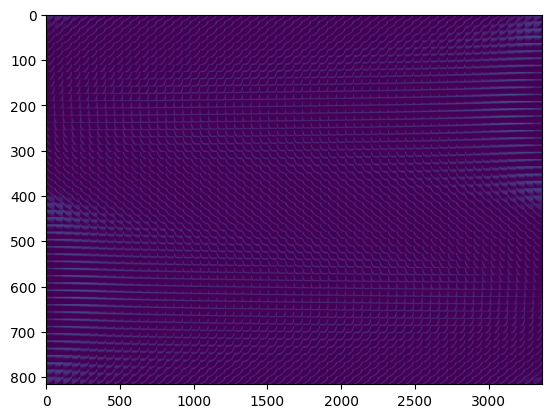

In [8]:
plt.imshow(weights.h.to.bvc, aspect='auto', vmax=.01)

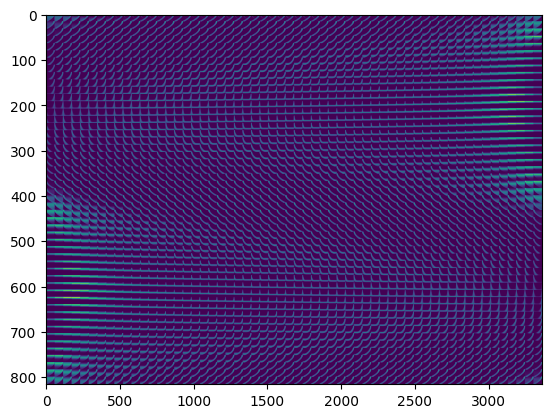

In [23]:
plt.imshow(weights_big.h.to.bvc, aspect='auto')

In [16]:
weights_big = DirectedTensorGroup.load('../data/weights/mtl_weights_trunc_square.pkl')

In [ ]:
weights.connection_map

,bvc,h,pr
bvc,1,1,1
h,1,1,1
pr,1,1,1


In [ ]:
weights.save('../data/weights/mtl_weights_trunc.pkl')

In [9]:
weights.save('../data/weights/mtl_weights_trunc_square.pkl')

## Head Direction Weights

In [10]:
config_path = '../cfg/cells/hd_cells.ini'
config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
config.read(config_path)

neurons_cfg = config['Neurons']
n_hd = neurons_cfg.eval('n_neurons')
amp_max = neurons_cfg.eval('max_amplitude')
sig_scaled = neurons_cfg.eval('sigma', locals={'pi': np.pi})

training_cfg = config['Training']
n_steps = training_cfg.eval('n_steps')
dt = training_cfg.eval('dt')
log_size = training_cfg.eval('log_size')
decay = training_cfg.eval('decay')

weights = HDGenerator(
    n_hd,
    amp_max,
    sig_scaled,
    n_steps,
    dt,
    log_size,
    decay
).generate()

In [ ]:
weights.connection_map

,rot,hd
rot,1,0
hd,0,1


In [11]:
weights.save('../data/weights/hd_weights.pkl')

## Transformation circuit

In [12]:
hd_config_path = '../cfg/cells/hd_cells.ini'
hd_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
hd_config.read(hd_config_path)

mtl_config_path = '../cfg/cells/mtl_cells.ini'
mtl_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
mtl_config.read(mtl_config_path)

tr_config_path = '../cfg/cells/transformation_circuit.ini'
tr_config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
tr_config.read(tr_config_path)

r_max = mtl_config['Space'].eval('r_max')

mtl_grid_cfg = mtl_config['PolarGrid']
n_radial_points = mtl_grid_cfg.eval('n_radial_points')
polar_dist_res = mtl_grid_cfg.eval('polar_dist_res')
polar_ang_res = mtl_grid_cfg.eval('polar_ang_res', locals={'pi': np.pi})
h_sig = mtl_grid_cfg.eval('sigma_hill')

tr_space_cfg = tr_config['Space']
tr_res = tr_space_cfg.eval('tr_res', locals={'pi': np.pi})
res = tr_space_cfg.eval('res')

n_steps = tr_config['Training'].eval('n_steps')

hd_neurons_cfg = hd_config['Neurons']
sigma_angular = hd_neurons_cfg.eval('sigma', locals={'pi': np.pi})
n_hd = hd_neurons_cfg.eval('n_neurons')

weights = TCGenerator(
    n_hd,
    tr_res,
    res,
    r_max,
    polar_dist_res,
    n_radial_points,
    polar_ang_res,
    sigma_angular,
    n_steps=n_steps
).generate()

In [13]:
weights.connection_map

,hd,tr,pw,bvc
hd,0,1,0,0
tr,0,0,1,1
pw,0,1,0,0
bvc,0,1,0,0


In [14]:
weights.save('../data/weights/tc_weights.pkl')

## Grid Cells Firing Rate Map

In [15]:
cfg_path = '../cfg/cells/grid_cells.ini'
config = EvalConfigParser()
config.read(cfg_path)

space_config = config['Space']
n_mod = space_config.eval('n_mod')
n_per_mod = space_config.eval('n_per_mod')

neurons_config = config['Neurons']
f_mods = neurons_config.eval('f_mods', locals={'pi': np.pi})
fac = neurons_config.eval('FAC')
r_size = neurons_config.eval('r_size')
orientations = neurons_config.eval('orientations', locals={'pi': np.pi})


frmap = GCGenerator(
    env,
    n_mod,
    n_per_mod,
    f_mods,
    fac,
    r_size,
    orientations
).generate()

In [16]:
frmap.save('../data/weights/gc_map.pkl')

## Place Cells

In [17]:
class PCGenerator(AbstractGenerator):
    """
    A class for calculating place cell weight matrices based on grid cell firing rate maps and specified parameters.
    """
    def __init__(
        self,
        env: Environment,
        n_mod: int,
        n_per_mod: int,
        gc_map: GCMap
    ):
        """
        Initializes the PCGenerator.

        Args:
            env (Environment): Environment object.
            n_mod (int): Number of modules.
            n_per_mod (int): Number of cells per module.
            gc_map (GCMap): Instance of GCMap containing grid cell firing rate maps.
        """
        self.gc_map = gc_map


        self.res = env.params.res
        coords_x, coords_y = env.params.coords[:, 0], env.params.coords[:, 1]
        min_train_x, max_train_x, min_train_y, max_train_y = min(coords_x), max(coords_x), min(coords_y), max(coords_y)

        self.n_mod = n_mod
        self.n_per_mod = n_per_mod
        self.n_points_x = int((max_train_x - min_train_x)/self.res)
        self.n_points_y = int((max_train_y - min_train_y)/self.res)
        self.n_gc = self.n_mod * self.n_per_mod
        self.n_pc = self.n_points_x*self.n_points_y

    def generate_gc2pc_weights(self):
        gc2pc_weights = np.zeros((self.n_pc, self.n_gc))
        shape = self.gc_map.fr.shape
        pc_template = np.zeros((shape[0], shape[1]))

        for x in range(self.n_points_x):
            for y in range(self.n_points_y):
                PC = pc_template.copy()
                PC[x, y] = 1

                for i in range(self.n_mod):
                    for j in range(self.n_per_mod):
                        gc2pc_weights[x * self.n_points_x + y, i * self.n_per_mod + j] = np.max(PC * self.gc_map.fr[:, :, j, i])

        return gc2pc_weights

    def generate(self) -> np.ndarray:
        """
        Generate place cell weight matrix based on grid cell firing rate maps.

        Args:
            save (bool, optional): Whether to save the generated weight matrix. Defaults to False.

        Returns:
            np.ndarray: Generated place cell weight matrix.
        """
        gc2pc_weights = self.generate_gc2pc_weights()

        return DirectedTensorGroup(
            DirectedTensor(
                from_='gc',
                to='h',
                weights=gc2pc_weights
            )
        )

In [18]:
gc_cfg_path = '../cfg/cells/grid_cells.ini'
gc_config = EvalConfigParser()
gc_config.read(gc_cfg_path)

pc_cfg_path = '../cfg/cells/place_cells.ini'
pc_config = EvalConfigParser()
pc_config.read(pc_cfg_path)

gc_space_config = gc_config['Space']
n_mod = gc_space_config.eval('n_mod')
n_per_mod = gc_space_config.eval('n_per_mod')

pc_space_config = pc_config['Space']
res = pc_space_config.eval('res')
x_max = pc_space_config.eval('x_max')
y_max = pc_space_config.eval('y_max')

weights = PCGenerator(
    env,
    n_mod=7,
    n_per_mod=100,
    gc_map=GCMap.load('../data/weights/gc_map.pkl')
).generate()

In [20]:
weights.gc.to.h.shape

(3364, 700)

In [ ]:
weights.connection_map

,gc,h
gc,0,1


In [19]:
weights.save('../data/weights/pc_weights_trunc.pkl')